## Mount drive and set current directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
print(os.getcwd())
os.chdir('/content/drive/My Drive/1006')
print(os.getcwd())

/content
/content/drive/My Drive/1006


## Load csv and clean the text

In [ ]:
# Imports
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
from itertools import groupby
import nltk
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import WordPunctTokenizer
import matplotlib.pyplot as plt

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
data = pd.read_csv('executive_orders.csv', encoding = "ISO-8859-1")
data.head()

,Unnamed: 0,docnum,doctype,Significance,accession,year,docname,id,date,text
0,1,2038,PR,1.0,1933-PR-2038,1933,1933-PR-2038.pdf/1933-PR-2038._v2.txt,46109,"Mar. 5, 1933",M667 7- /a- Ygvy DU. S KOU lac C (awn | has Us...
1,2,2039,PR,1.0,1933-PR-2039,1933,1933-PR-2039.pdf/1933-PR-2039._v2.txt,46110,"Mar. 6, 1933",4 } ~ = Mien ef mercer eee eS IRE Cee NNN ETc...
2,3,2040,PR,1.0,1933-PR-2040,1933,1933-PR-2040.pdf/1933-PR-2040._v2.txt,46111,"Mar. 9, 1933",nA [ofeaaPevecery | ae .  : we  > * : ; 4 th...
3,4,2041,PR,0.0,1933-PR-2041,1933,1933-PR-2041.pdf/1933-PR-2041._v2.txt,46112,"Mar. 15, 1933",. se * oe ae ° / . ; i gH er ~ f ;  ee EE ram...
4,5,2042,PR,0.0,1933-PR-2042,1933,1933-PR-2042.pdf/1933-PR-2042._v2.txt,46113,"Mar. 15, 1933",ey a + we. . s . Lo TP z= as oe a Oe Re nae =...


In [ ]:
# Drop rows without any executive order (empty text column)
data.dropna(axis=0, inplace=True)
len(data)

10722

In [ ]:
# Contractions expansion dictionary
contractions_dic = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who has",
"who've": "who have",
"why's": "why has",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",
"isn't":"is not",
"aren't":"are not",
"wasn't":"was not",
"weren't":"were not", 
"haven't":"have not",
"hasn't":"has not",
"hadn't":"had not",
"won't":"will not",
"wouldn't":"would not",
"don't":"do not", 
"doesn't":"does not",
"didn't":"did not",
"can't":"can not",
"couldn't":"could not",
"shouldn't":"should not",
"mightn't":"might not",
"mustn't":"must not"}

In [ ]:
# Preprocessing the text
contrac_pattern = re.compile(r'\b(' + '|'.join(contractions_dic.keys()) + r')\b')
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))
def load_words():
    with open('words_alpha.txt') as word_file:
        valid_words = set(word_file.read().split())
    return valid_words
words = set(nltk.corpus.words.words())
words = words.union(load_words())

def text_cleaner(text, isTokenized=False):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    lower_case=""
    for i in range(0, len(text)):
        if text[i].isalpha():
            lower_case = lower_case + text[i].lower()
        elif text[i].isdigit():
            lower_case = lower_case
        else:
            lower_case = lower_case+text[i]
    contrac_handled = contrac_pattern.sub(lambda x: contractions_dic[x.group()], lower_case)
    sentc = re.sub("[^a-zA-Z]", " ", contrac_handled)
    sentc = ' '.join(sentc.split())
    sentc = ' '.join([w for w in sentc.split() if len(w)>1])
    sentc = ' '.join(item[0] for item in groupby(sentc.split()))
    sentc = ' '.join(w for w in nltk.wordpunct_tokenize(sentc) if w in words)
    if isTokenized:
      sentc = [x for x in tok.tokenize(sentc)]
    return sentc

In [ ]:
# Apply text_cleaner
data['text'] = data['text'].apply(text_cleaner)

In [ ]:
data['text'] = data['text'].replace('', np.NaN)
data.dropna(axis=0, inplace=True)
len(data)

10702

In [ ]:
# Create a list 'lens' with lengths of words for different reviews
# Also print maxlength and corresponding index
maxlen = 0
index = -1
lens = []
for i in range(len(data)):
  currlen = len(data['text'].iloc[i].split())
  lens.append(currlen)
  if currlen > maxlen:
    maxlen = currlen
    index = i
print(maxlen, index)

39686 7589


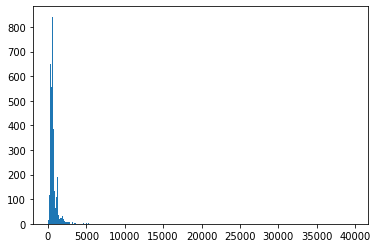

In [ ]:
# Plot distribution of the lengths
plt.hist(lens, bins=1000)
plt.show()

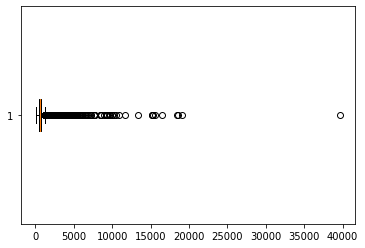

In [ ]:
plt.boxplot(lens, vert=False)
plt.show()

In [ ]:
lens = np.array(lens)

In [ ]:
lens[lens<3000].shape

(10547,)

In [ ]:
data = data[data['text'].str.split().str.len().lt(3000)]
print(len(data))
results = set()
data['text'].str.lower().str.split().apply(results.update)
print(len(results))

10547
30908


## Separating the test data

In [ ]:
data.columns

Index(['Unnamed: 0', 'docnum', 'doctype', 'Significance', 'accession', 'year',
       'docname', 'id', 'date', 'text'],
      dtype='object')

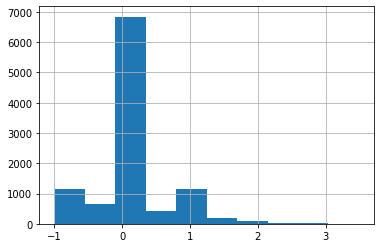

In [ ]:
data['Significance'].hist(bins=10)

In [ ]:
## Convert significance scores to binary labels.
data['label'] = np.where(data['Significance']<=0.35, 0, 1)

In [ ]:
data['label'].value_counts()

0    8658
1    1889
Name: label, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42, stratify=data['label'])

In [ ]:
pd.concat([X_train, y_train], axis=1).to_csv('eo_clean_train.csv')

In [ ]:
pd.concat([X_test, y_test], axis=1).to_csv('eo_clean_test.csv')

## 20NewsGroups Dataset

In [ ]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(subset='all', shuffle=True, remove = ('headers', 'footers', 'quotes'))

In [ ]:
len(newsgroups.data)

18846

In [ ]:
newsgroups.data[:5]

["\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n",
 'My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:\n\n  - Diamond Stealth Pro Local Bus\n\n  - Orchid Farenheit 1280\n\n  - ATI Graphics Ultra Pro\n\n  - Any other high-per

In [ ]:
def text_cleaner(text, isTokenized=False):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    lower_case=""
    for i in range(0, len(text)):
        if text[i].isalpha():
            lower_case = lower_case + text[i].lower()
        else:
            lower_case = lower_case+text[i]
    contrac_handled = contrac_pattern.sub(lambda x: contractions_dic[x.group()], lower_case)
    sentc = re.sub('\s+', ' ', contrac_handled)
    sentc = re.sub("[^0-9a-zA-Z]", " ", sentc)
    sentc = ' '.join([w for w in sentc.split() if len(w)>1])
    sentc = ' '.join(item[0] for item in groupby(sentc.split()))
    if isTokenized:
      sentc = [x for x in tok.tokenize(sentc)]
    return sentc

In [ ]:
data = pd.concat([pd.Series(newsgroups.data).rename('text'), pd.Series(newsgroups.target).rename('label')], axis=1)
len(data)

18846

In [ ]:
# Apply text_cleaner
data['text'] = data['text'].apply(text_cleaner)
data['text'] = data['text'].replace('', np.NaN)
data.dropna(axis=0, inplace=True)
len(data)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


18311

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42, stratify=data['label'])

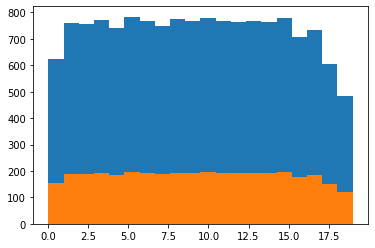

In [ ]:
plt.hist(y_train, bins=20)
plt.hist(y_test, bins=20)
plt.show()

In [ ]:
pd.concat([X_train, y_train], axis=1).to_csv('news_clean_train.csv')

In [ ]:
pd.concat([X_test, y_test], axis=1).to_csv('news_clean_test.csv')

## Twitter Dataset

In [ ]:
data = pd.read_csv('ExtractedTweets.csv')
data.head()

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...


In [ ]:
len(data)

86460

In [ ]:
def text_cleaner(text, isTokenized=False):
    text = re.compile('RT @').sub('@', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub('@[^\s]+', '', text)
    lower_case = ""
    for i in range(0, len(text)):
        if text[i].isalpha():
            lower_case = lower_case + text[i].lower()
        else:
            lower_case = lower_case+text[i]
    contrac_handled = contrac_pattern.sub(lambda x: contractions_dic[x.group()], lower_case)
    sentc = re.sub('\s+', ' ', contrac_handled)
    sentc = re.sub("[^0-9a-zA-Z]", " ", sentc)
    sentc = ' '.join([w for w in sentc.split() if len(w)>1])
    sentc = ' '.join(item[0] for item in groupby(sentc.split()))
    if isTokenized:
      sentc = [x for x in tok.tokenize(sentc)]
    return sentc

In [ ]:
# Apply text_cleaner
data['Tweet'] = data['Tweet'].apply(text_cleaner)
data['Tweet'] = data['Tweet'].replace('', np.NaN)
data.dropna(axis=0, inplace=True)
len(data)

86014

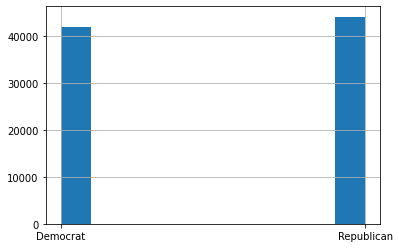

In [ ]:
data['Party'].hist()

In [ ]:
data['label'] = np.where(data['Party']=='Democrat', 0, 1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['Tweet'], data['label'], test_size=0.2, random_state=42, stratify=data['label'])

In [ ]:
pd.concat([X_train, y_train], axis=1).to_csv('twitter_clean_train.csv')

In [ ]:
pd.concat([X_test, y_test], axis=1).to_csv('twitter_clean_test.csv')